# 教師なし異常検知

## [流れ]

    1. 正常時データのパターンを発見
    2. 1より正常・異常の境目となる閾値を設定
    3. 観測データから閾値を超えたら異常発生と判断

## [今回使用するデータ]

- FPで計測した周波数
- 50個の正常なFPGA ＋ 2個の経年劣化させたFPGA 

    - FPGAは，それぞれ3964個の特徴量（周波数）を持つ
    - 測定値が0の部分は考慮しない (FPGAの構造上必ず生じる）
    - 経年劣化に発生したバグも無視
    
---------------------------------------------------------------
    
# 今回の実験

## [残差データ]

- データから残差データを作り出す

    - 残差は「元の測定値 - 推定値」と定義する．
    - 推定値は「上下左右データの平均値」と「周囲８個のデータの平均値」の2種類定義する．
      (なお「四隅，縁」は前回と同様の扱いとする）

## [試した手法]

- 教師なし異常検知アルゴリズム

    - ホテリング理論
    - IsolationForest
    - Kmeans++
    
    
- 階層ベイズモデル

    - 二項分布
    - ポアソン分布
    - ガンマ分布
　
--------------------------------------------------------------------------

# このPDFはデータの性質を調べた結果を示す

- データの可視化&正規性の確認
- 2種類の残差データの可視化&正規性の確認

# 可視化方法

- sns.distplotで可視化（確率密度関数（カーネル密度推定））
    - x軸はデータの値，y軸はその密度を示す

# 正規性の検定

## [QQプロット]

- QQプロットとは、X軸上に観測した累積パーセント、Y軸上に期待累積パーセントを持つグラフ
- 一直線上になっていれば正規分布
    
## [コルモゴロフスミルノフ検定 (KS検定） ]
## [シャピロウィルク検定]
- 得られたデータが正規分布に従うものか否かを調べる検定法.
     - データの分布が仮定した分布と一致するかを調べる
     
1. データが正規分布であるという帰無仮説を立てる
2. 帰無仮説「データの分布が仮定した分布に一致している」を棄却できるか調べる
    - 棄却できないからといって，正規分布と一致しているわけではない
    - p値が0.05以下の場合は棄却する(つまりp値が0.05以上なら正規分布)

In [14]:
import numpy as np
import pandas as pd

data = []
for i in range(1, 51):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'.csv', header=None).values
    data.append(tmp_data)
for i in range(1, 3):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'_aged.csv', header=None).values
    data.append(tmp_data)
data = np.array(data)

check = []
for i in range(148):
    for j in range(33):
        if data[0, i, j] == 0:
            check.append([i,j])
for i in range(52):
    for j in range(148):
        for k in range(33):
            if [j,k] in check:
                data[i, j, k] = 0

tmp_1 = []
for i in range(52):
    tmp_2 = data[i].flatten()
    tmp_1.append(tmp_2[tmp_2 != 0])
data = np.array(tmp_1)

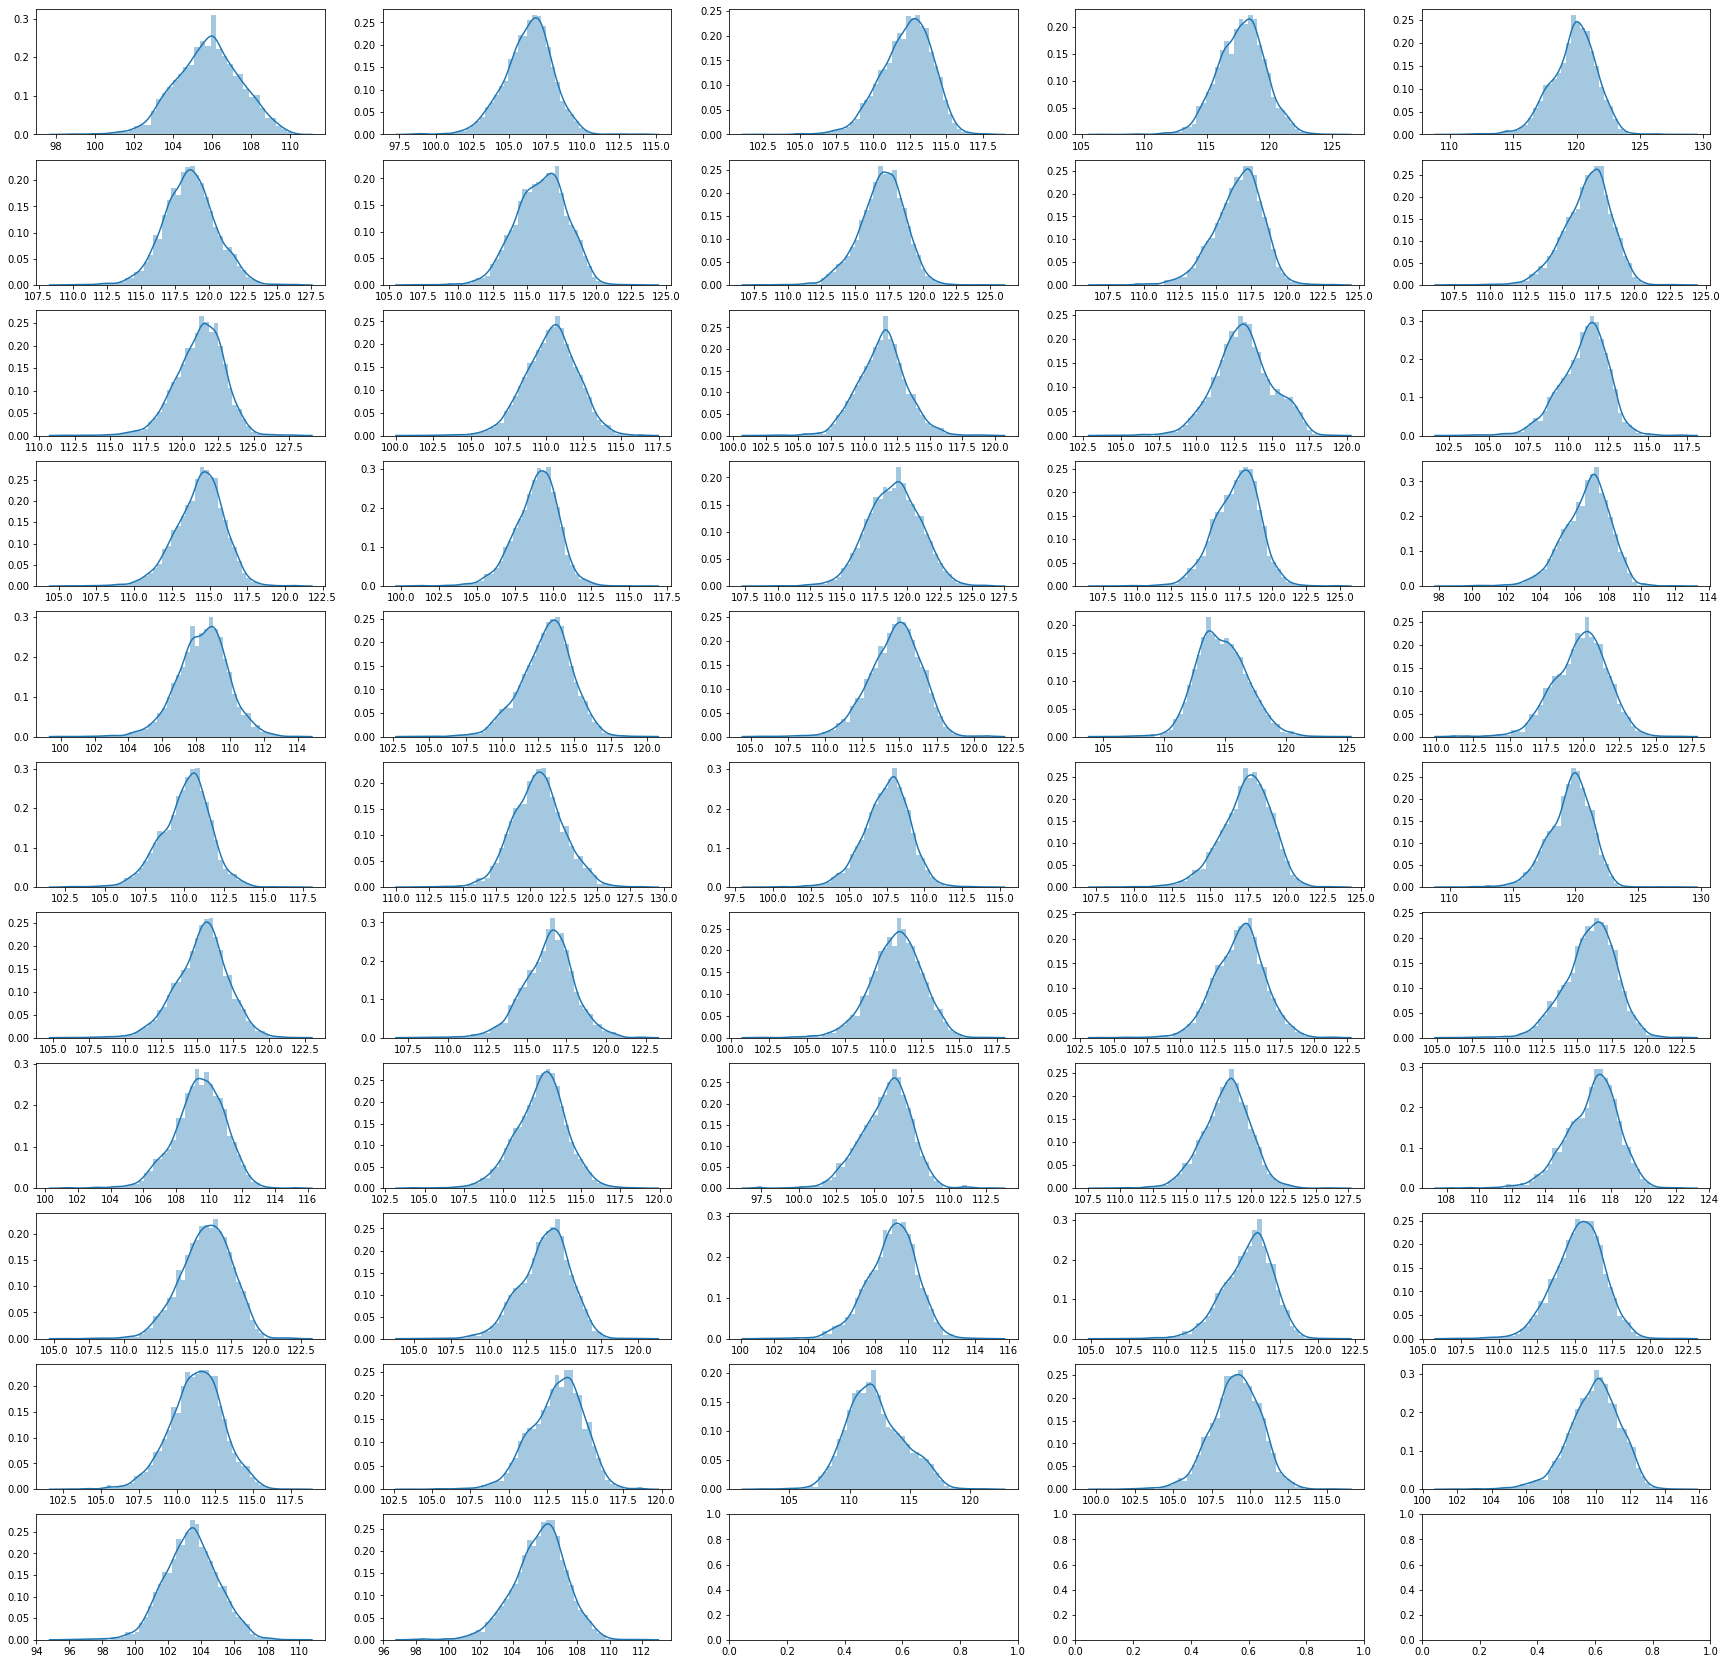

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

y = 11
x = 5
fig, ax = plt.subplots(y, x, figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 52:
            break
        tmp = sns.distplot(data[count], ax=ax[i,j])
        count += 1
    if count >= 52:
        break
        
plt.show()

[new]

QQプロット


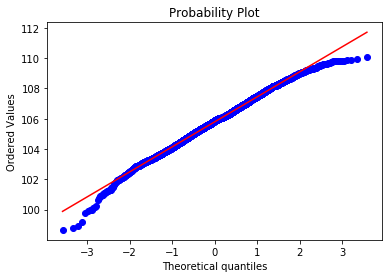

コルモゴロフスミルノフ検定:0.17664074847314698
シャピロウィルク検定:4.284796961684378e-09

QQプロット


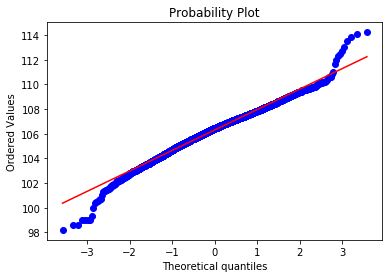

コルモゴロフスミルノフ検定:7.78987420010969e-05
シャピロウィルク検定:7.951204361789677e-19

---------------------------------------------
[aged]

QQプロット


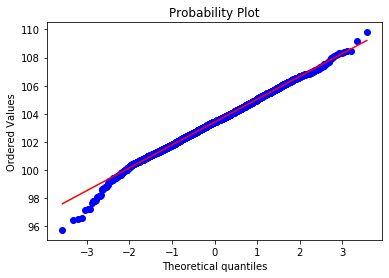

コルモゴロフスミルノフ検定:0.5156782058868354
シャピロウィルク検定:4.7392410351676517e-07

QQプロット


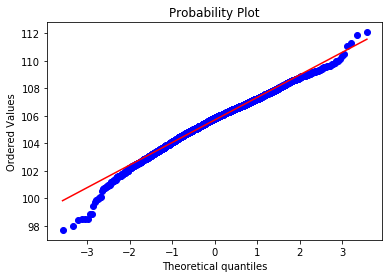

コルモゴロフスミルノフ検定:0.00011315372252185875
シャピロウィルク検定:1.5443250278128213e-16



In [16]:
from scipy import stats
from scipy.stats import norm

"""QQプロット出力する関数"""
def qq(x):
    stats.probplot(x, dist="norm", plot=plt)  #QQプロット表示
    plt.show()

    
"""コルモゴロフスミルノフ検定する関数"""
def kolmogorov_smirnov(x):
    loc, scale = norm.fit(x)
    n = norm(loc=loc, scale=scale)  # create a normal distribution with loc and scale
    p = stats.kstest(x, n.cdf).pvalue  #コルモゴロフスミルノフ検定
    return p


"""シャピロウィルク検定する関数"""
def shapiro_wilk(x):
    p=stats.shapiro(x)[1]  #シャピロウィルク検定
    return p


print('[new]')
print()
for i in range(2):
    print('QQプロット')
    qq(data[i])
    a = kolmogorov_smirnov(data[i])
    b = shapiro_wilk(data[i])
    
    print(f'コルモゴロフスミルノフ検定:{a}')
    print(f'シャピロウィルク検定:{b}')
    print()

print('---------------------------------------------')
    
print('[aged]')
print()
for i in range(50, 52):
    print('QQプロット')
    qq(data[i])
    a = kolmogorov_smirnov(data[i])
    b = shapiro_wilk(data[i])
    
    print(f'コルモゴロフスミルノフ検定:{a}')
    print(f'シャピロウィルク検定:{b}')
    print()

In [17]:
count_kol = 0
count_sha = 0
for i in data:
    k = kolmogorov_smirnov(i)
    s = shapiro_wilk(i)
    
    if k < 0.05:
        count_kol += 1
    if s < 0.05:
        count_sha += 1

print('[棄却数]')
print(f'コルモゴロフスミルノフ検定:  {count_kol}')
print(f'シャピロウィルク検定:       {count_sha}')

[棄却数]
コルモゴロフスミルノフ検定:  47
シャピロウィルク検定:       52


## 検定結果
- FPGAの測定値は正規分布に従っているとはいえない．

---------------------------------------

## 残差データを調べる

- 今回は残差データが2種類
    
    - 上下左右四方向データで推定
    - 周囲八方向データで推定


In [21]:
data = []
for i in range(1, 51):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'.csv', header=None).values
    data.append(tmp_data)
for i in range(1, 3):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'_aged.csv', header=None).values
    data.append(tmp_data)
data = np.array(data)

check = []
for i in range(148):
    for j in range(33):
        if data[0, i, j] == 0:
            check.append([i,j])
for i in range(52):
    for j in range(148):
        for k in range(33):
            if [j,k] in check:
                data[i, j, k] = 0

tmp_x = [0, 1, 0, -1]
tmp_y = [-1, 0, 1, 0]
residual_data = np.zeros_like(data)
for i in range(52):
    for j in range(148):
        for k in range(33):
            if data[i, j, k] != 0:
                data_list = []
                for l in range(4):
                    next_y = j + tmp_y[l]
                    next_x = k + tmp_x[l]
                    if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                        data_list.append(data[i, next_y, next_x])

                data_mean = np.mean(np.array(data_list))
                residual_data[i, j, k] = data[i, j, k] - data_mean

tmp_1 = []
for i in range(52):
    tmp_2 = []
    for j in range(148):
        for k in range(33):
            if [j,k] in check:
                continue
            else:
                tmp_2.append(residual_data[i, j, k])
    tmp_1.append(tmp_2)
data = np.array(tmp_1)

[四方向]


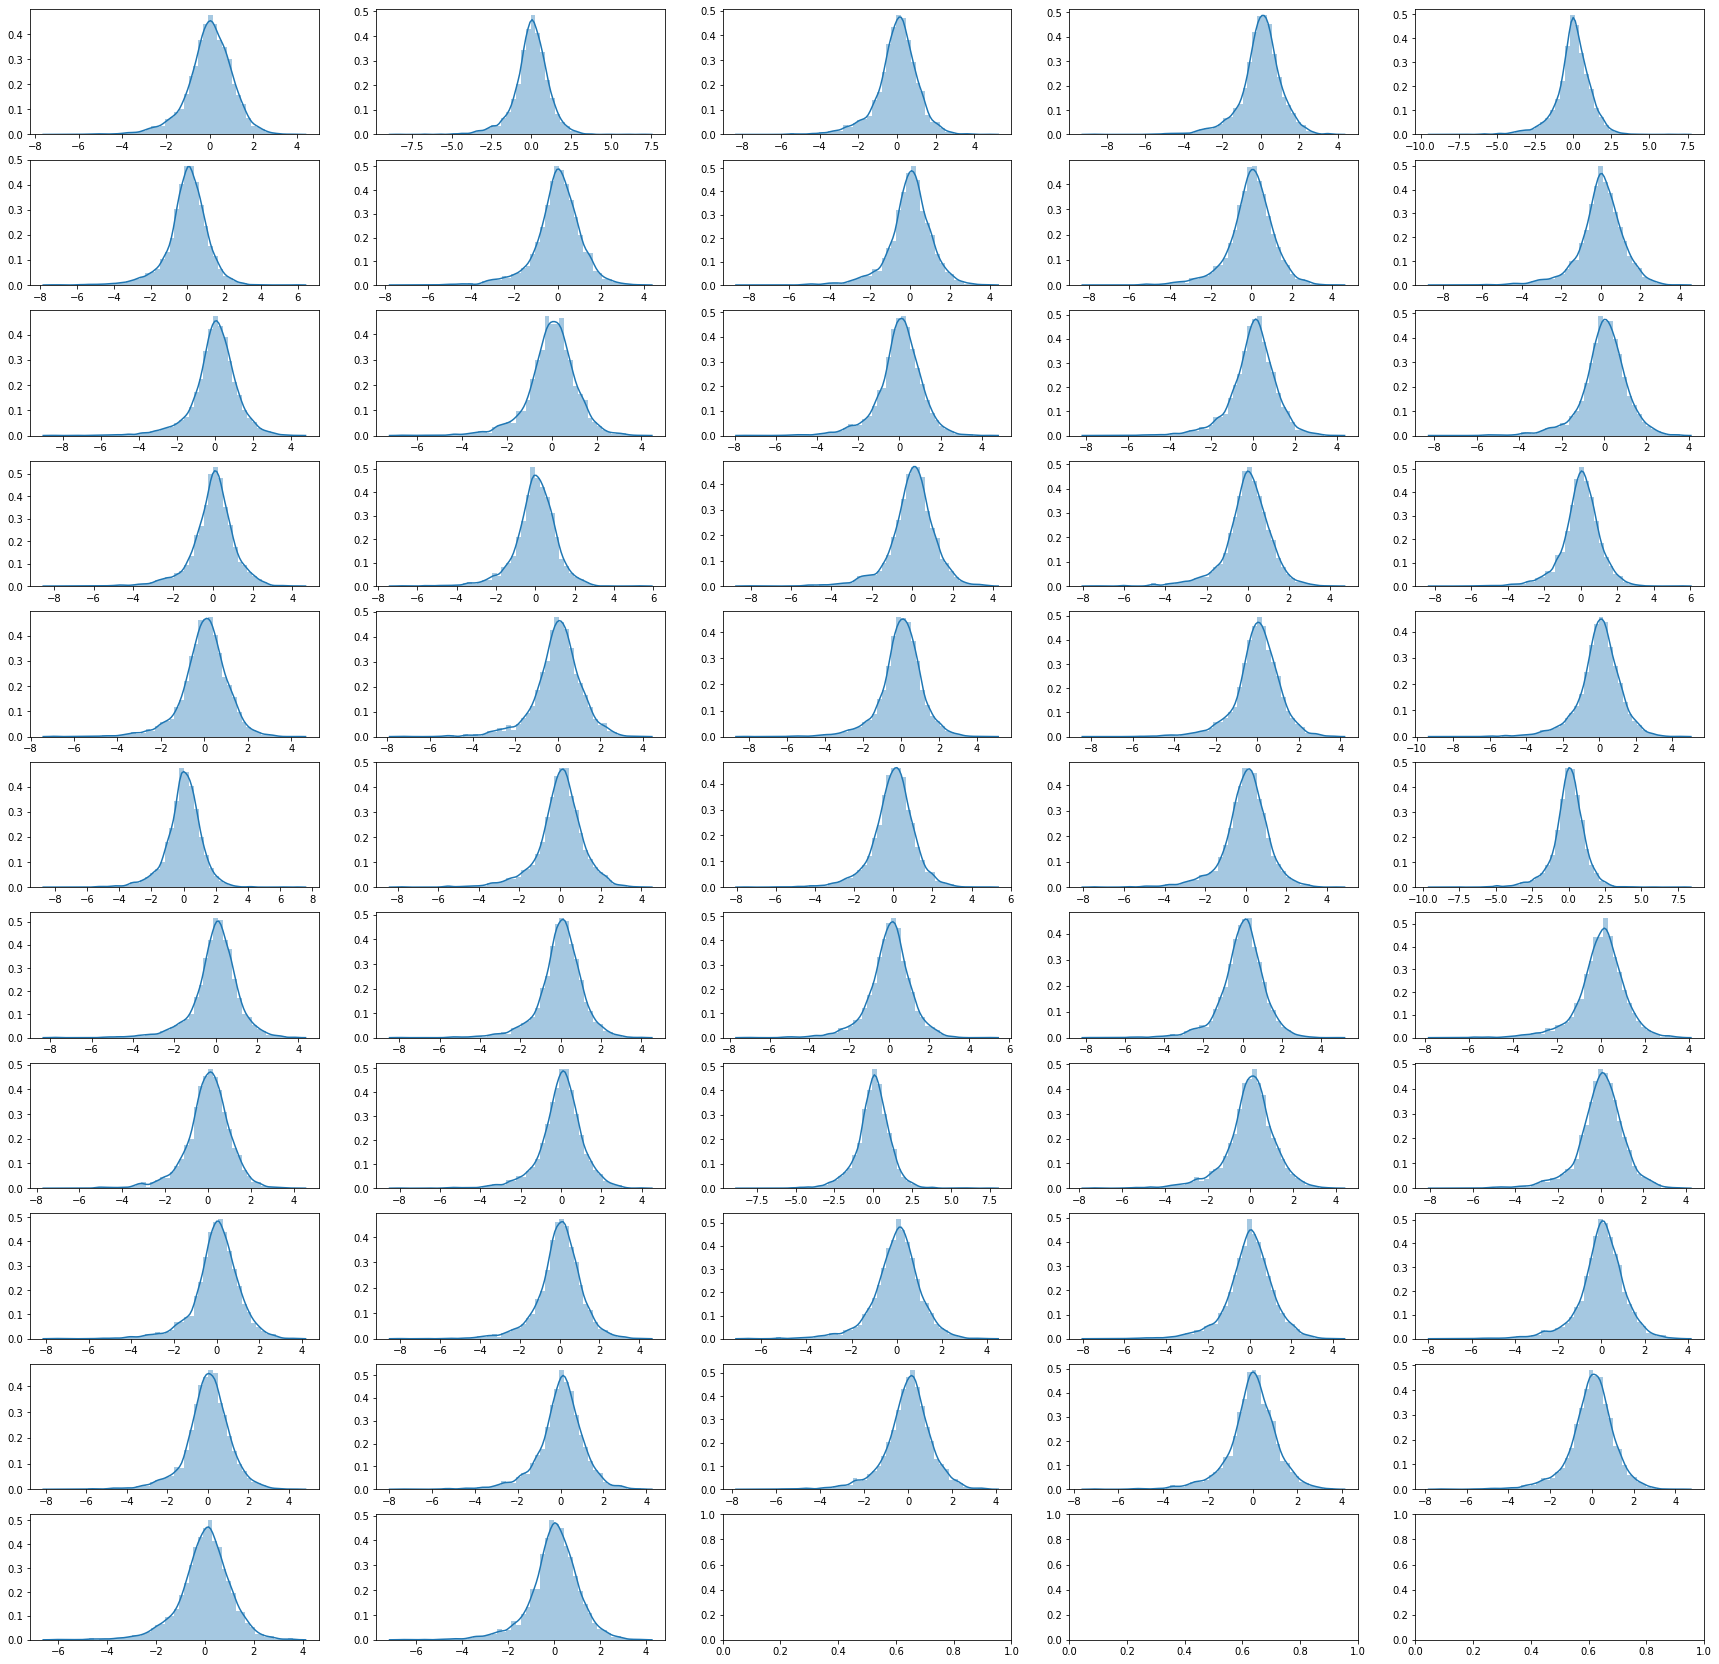

In [22]:
y = 11
x = 5
fig, ax = plt.subplots(y, x, figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 52:
            break
        tmp = sns.distplot(data[count], ax=ax[i,j])
        count += 1
    if count >= 52:
        break
print('[四方向]')        
plt.show()

[new]

QQプロット


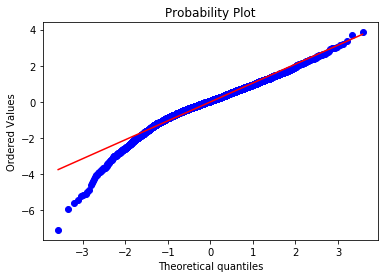

コルモゴロフスミルノフ検定:1.0801957203177085e-12
シャピロウィルク検定:1.757709142004902e-29

QQプロット


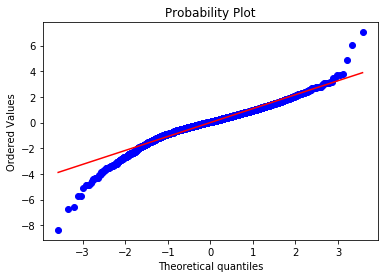

コルモゴロフスミルノフ検定:5.939879071458392e-18
シャピロウィルク検定:5.224794678864686e-33

---------------------------------------------
[aged]

QQプロット


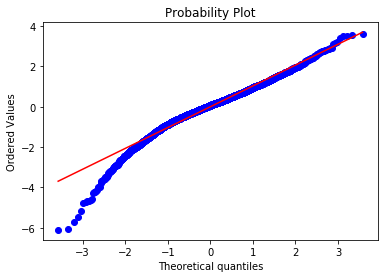

コルモゴロフスミルノフ検定:6.6577408551644415e-12
シャピロウィルク検定:8.075122728408762e-29

QQプロット


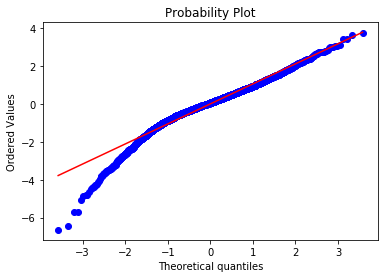

コルモゴロフスミルノフ検定:1.3045282312972652e-16
シャピロウィルク検定:6.322994927621112e-31



In [23]:
print('[new]')
print()
for i in range(2):
    print('QQプロット')
    qq(data[i])
    a = kolmogorov_smirnov(data[i])
    b = shapiro_wilk(data[i])
    
    print(f'コルモゴロフスミルノフ検定:{a}')
    print(f'シャピロウィルク検定:{b}')
    print()

print('---------------------------------------------')
    
print('[aged]')
print()
for i in range(50, 52):
    print('QQプロット')
    qq(data[i])
    a = kolmogorov_smirnov(data[i])
    b = shapiro_wilk(data[i])
    
    print(f'コルモゴロフスミルノフ検定:{a}')
    print(f'シャピロウィルク検定:{b}')
    print()

In [24]:
count_kol = 0
count_sha = 0
for i in data:
    k = kolmogorov_smirnov(i)
    s = shapiro_wilk(i)
    
    if k < 0.05:
        count_kol += 1
    if s < 0.05:
        count_sha += 1

print('[棄却数]')
print(f'コルモゴロフスミルノフ検定:  {count_kol}')
print(f'シャピロウィルク検定:       {count_sha}')

[棄却数]
コルモゴロフスミルノフ検定:  52
シャピロウィルク検定:       52


In [26]:
data = []
for i in range(1, 51):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'.csv', header=None).values
    data.append(tmp_data)
for i in range(1, 3):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'_aged.csv', header=None).values
    data.append(tmp_data)
data = np.array(data)

check = []
for i in range(148):
    for j in range(33):
        if data[0, i, j] == 0:
            check.append([i,j])
for i in range(52):
    for j in range(148):
        for k in range(33):
            if [j,k] in check:
                data[i, j, k] = 0

tmp_x = [-1, 0, 1, 1, 1, 0, -1, -1]
tmp_y = [-1, -1, -1, 0, 1, 1, 1, 0]
residual_data = np.zeros_like(data)
for i in range(52):
    for j in range(148):
        for k in range(33):
            if data[i, j, k] != 0:
                data_list = []
                for l in range(8):
                    next_y = j + tmp_y[l]
                    next_x = k + tmp_x[l]
                    if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                        data_list.append(data[i, next_y, next_x])
                data_mean = np.mean(np.array(data_list))
                residual_data[i, j, k] = data[i, j, k] - data_mean

tmp_1 = []
for i in range(52):
    tmp_2 = []
    for j in range(148):
        for k in range(33):
            if [j,k] in check:
                continue
            else:
                tmp_2.append(residual_data[i, j, k])
    tmp_1.append(tmp_2)
data = np.array(tmp_1)

[四方向]


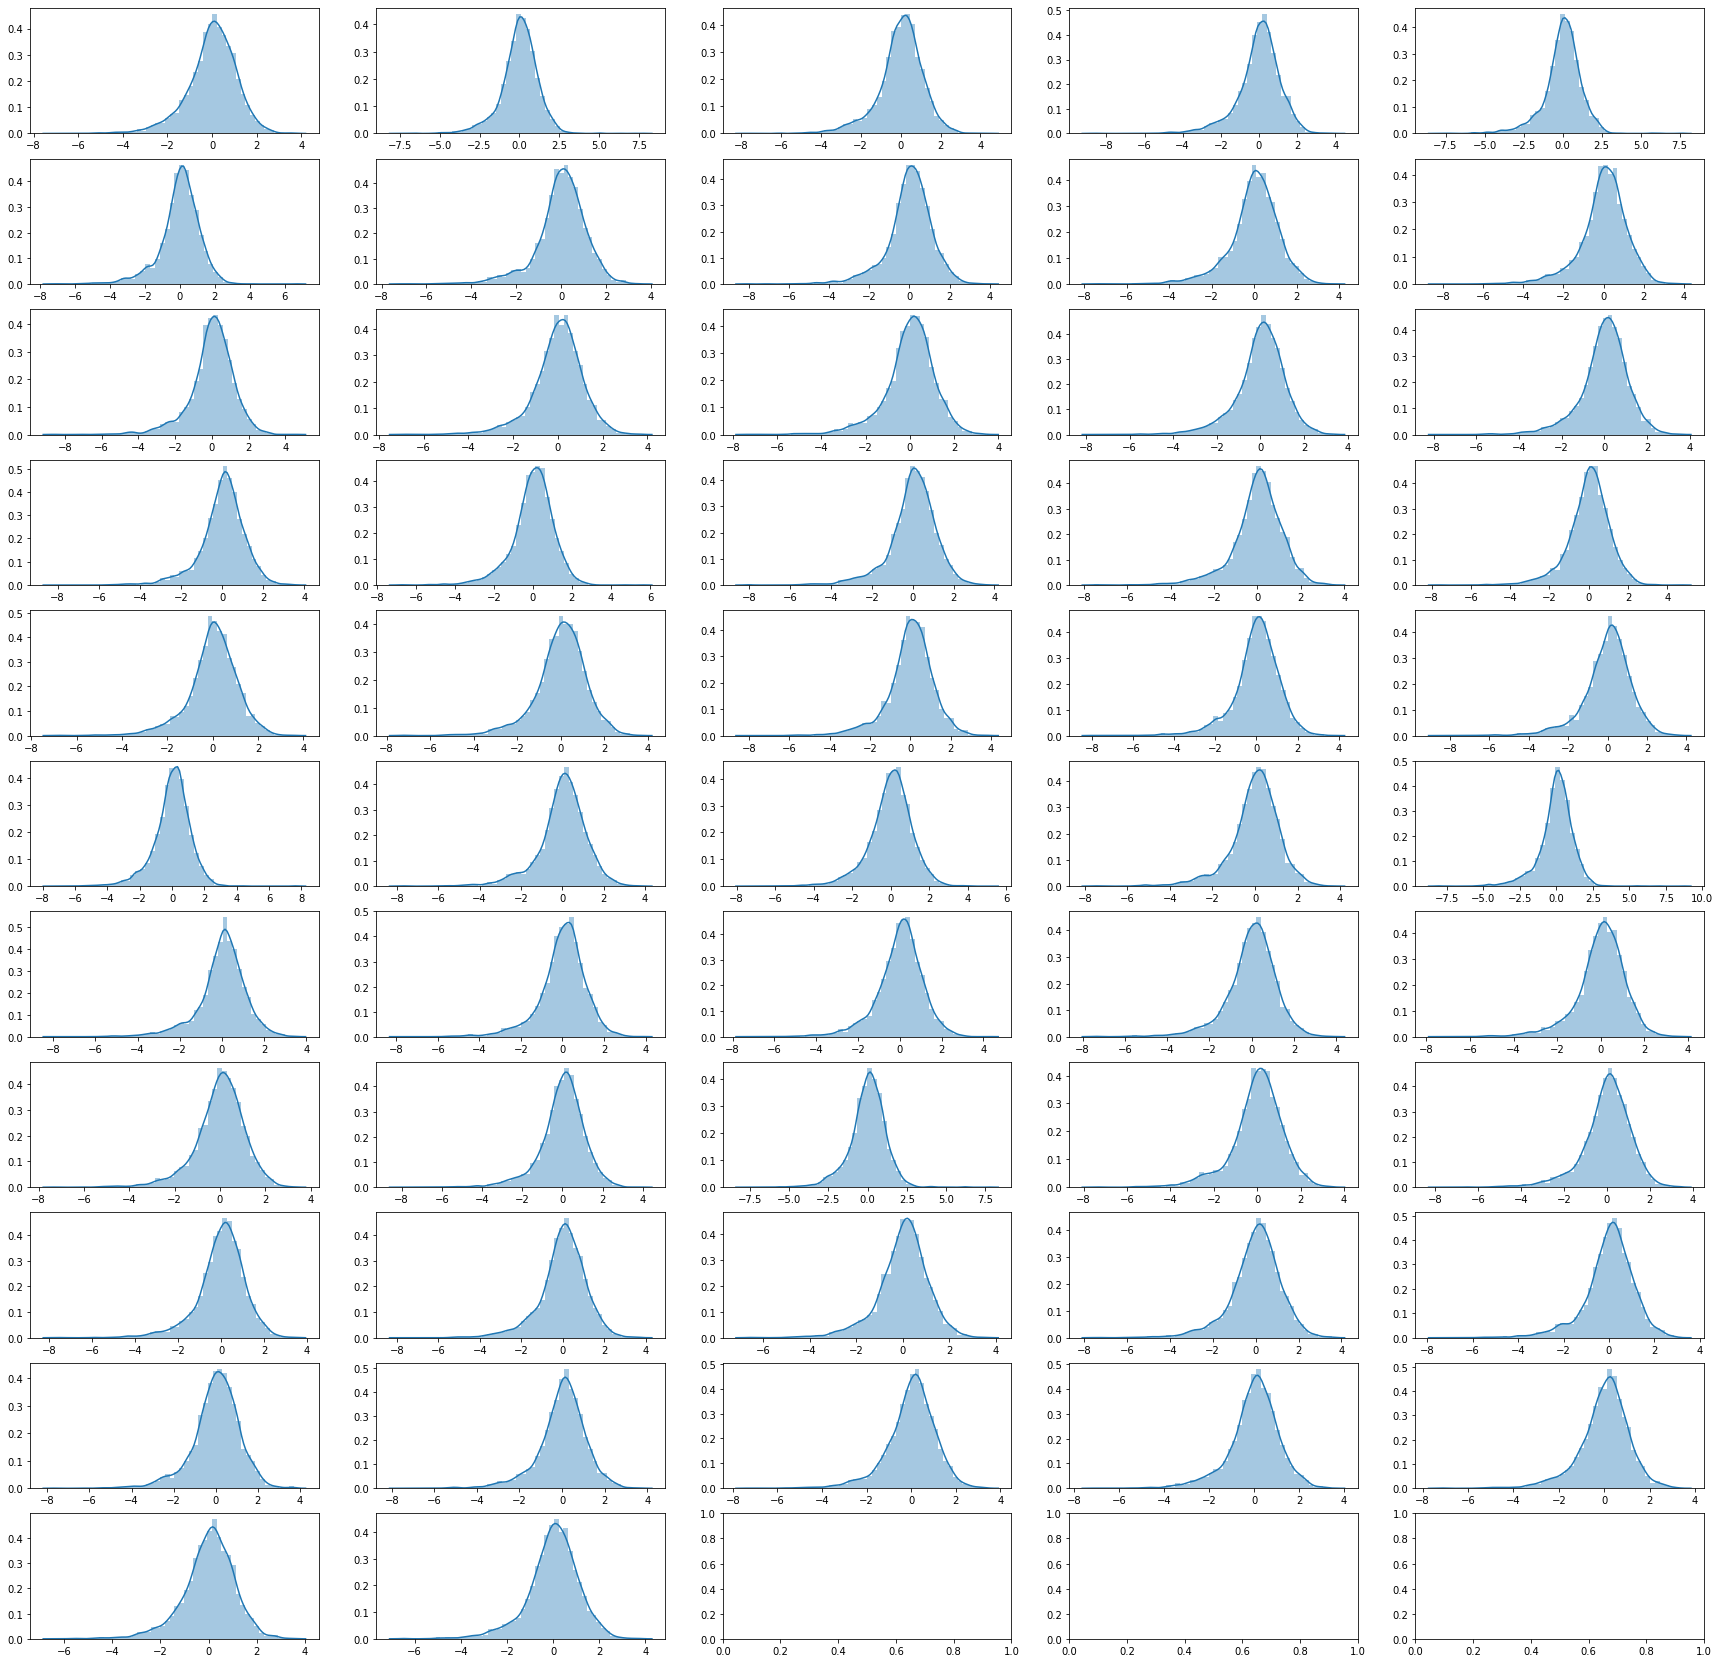

In [27]:
y = 11
x = 5
fig, ax = plt.subplots(y, x, figsize=(30,30))
count = 0
for i in range(y):
    for j in range(x):
        if count >= 52:
            break
        tmp = sns.distplot(data[count], ax=ax[i,j])
        count += 1
    if count >= 52:
        break
print('[四方向]')        
plt.show()

[new]

QQプロット


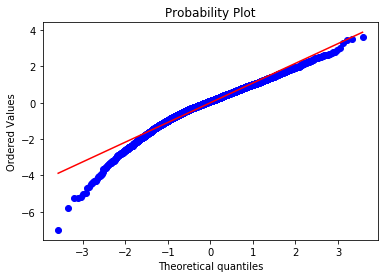

コルモゴロフスミルノフ検定:1.9980635895756283e-13
シャピロウィルク検定:1.8718944890494277e-28

QQプロット


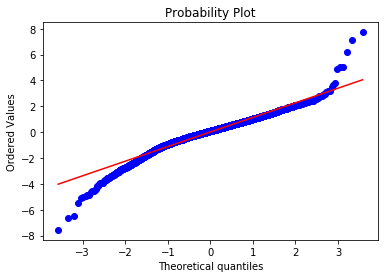

コルモゴロフスミルノフ検定:9.267389873171084e-14
シャピロウィルク検定:5.564766746905693e-32

---------------------------------------------
[aged]

QQプロット


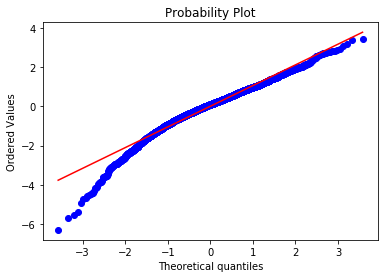

コルモゴロフスミルノフ検定:2.7645545775431366e-11
シャピロウィルク検定:2.8268891205388206e-28

QQプロット


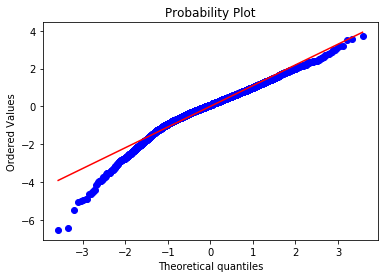

コルモゴロフスミルノフ検定:9.226870028421603e-13
シャピロウィルク検定:3.679877955859337e-29



In [28]:
print('[new]')
print()
for i in range(2):
    print('QQプロット')
    qq(data[i])
    a = kolmogorov_smirnov(data[i])
    b = shapiro_wilk(data[i])
    
    print(f'コルモゴロフスミルノフ検定:{a}')
    print(f'シャピロウィルク検定:{b}')
    print()

print('---------------------------------------------')
    
print('[aged]')
print()
for i in range(50, 52):
    print('QQプロット')
    qq(data[i])
    a = kolmogorov_smirnov(data[i])
    b = shapiro_wilk(data[i])
    
    print(f'コルモゴロフスミルノフ検定:{a}')
    print(f'シャピロウィルク検定:{b}')
    print()

In [29]:
count_kol = 0
count_sha = 0
for i in data:
    k = kolmogorov_smirnov(i)
    s = shapiro_wilk(i)
    
    if k < 0.05:
        count_kol += 1
    if s < 0.05:
        count_sha += 1

print('[棄却数]')
print(f'コルモゴロフスミルノフ検定:  {count_kol}')
print(f'シャピロウィルク検定:       {count_sha}')

[棄却数]
コルモゴロフスミルノフ検定:  52
シャピロウィルク検定:       52


## 検定結果
- 測定値の残差は正規分布に従っているとはいえない．

---------------------------------------

## 残差データの絶対値の合計値と平均値を調べる


In [30]:
data = []
for i in range(1, 51):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'.csv', header=None).values
    data.append(tmp_data)
for i in range(1, 3):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'_aged.csv', header=None).values
    data.append(tmp_data)
data = np.array(data)

check = []
for i in range(148):
    for j in range(33):
        if data[0, i, j] == 0:
            check.append([i,j])
for i in range(52):
    for j in range(148):
        for k in range(33):
            if [j,k] in check:
                data[i, j, k] = 0

tmp_x = [0, 1, 0, -1]
tmp_y = [-1, 0, 1, 0]
residual_data = np.zeros_like(data)
for i in range(52):
    for j in range(148):
        for k in range(33):
            if data[i, j, k] != 0:
                data_list = []
                for l in range(4):
                    next_y = j + tmp_y[l]
                    next_x = k + tmp_x[l]
                    if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                        data_list.append(data[i, next_y, next_x])

                data_mean = np.mean(np.array(data_list))
                residual_data[i, j, k] = abs(data[i, j, k] - data_mean)

tmp_1 = []
for i in range(52):
    tmp_2 = []
    for j in range(148):
        for k in range(33):
            if [j,k] in check:
                continue
            else:
                tmp_2.append(residual_data[i, j, k])
    tmp_1.append(tmp_2)
data = np.array(tmp_1)

[四方向,合計]



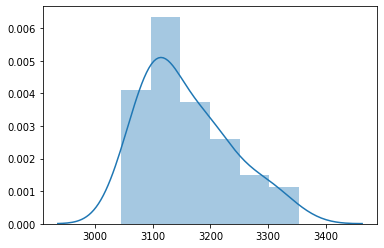

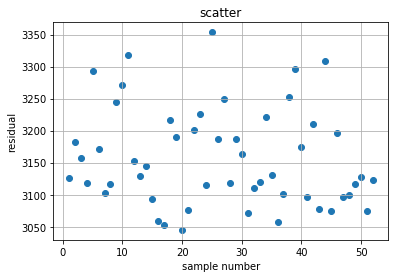

QQプロット


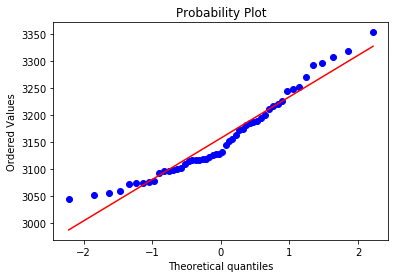

コルモゴロフスミルノフ検定:0.15127205560855006
シャピロウィルク検定:0.012513765133917332


In [41]:
sum_list = []
for i in data:
    sum_list.append(np.sum(i))

print('[四方向,合計]')
print()
sns.distplot(sum_list)
plt.show()

x = np.arange(1, 53)
plt.scatter(x,sum_list)
plt.title("scatter")
plt.xlabel("sample number")
plt.ylabel("residual")
plt.grid(True)
plt.show()

print('QQプロット')
qq(sum_list)
a = kolmogorov_smirnov(sum_list)
b = shapiro_wilk(sum_list)
    
print(f'コルモゴロフスミルノフ検定:{a}')
print(f'シャピロウィルク検定:{b}')

[四方向,合計]



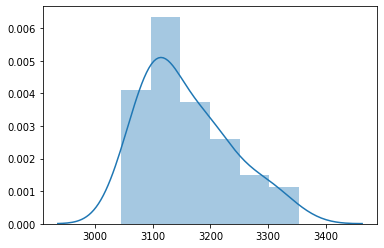

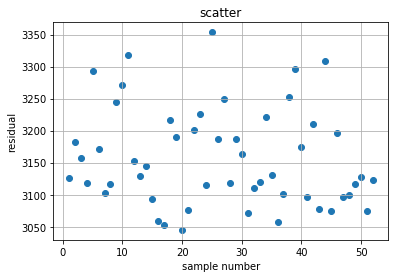

QQプロット


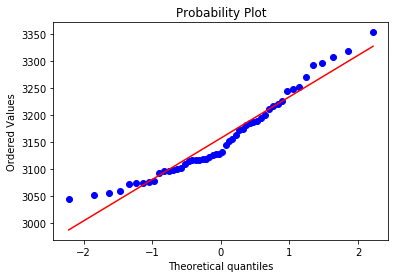

コルモゴロフスミルノフ検定:0.15127205560855006
シャピロウィルク検定:0.012513765133917332


In [42]:
mean_list = []
for i in data:
    mean_list.append(np.sum(i))

print('[四方向,合計]')
print()
sns.distplot(mean_list)
plt.show()

x = np.arange(1, 53)
plt.scatter(x,mean_list)
plt.title("scatter")
plt.xlabel("sample number")
plt.ylabel("residual")
plt.grid(True)
plt.show()

print('QQプロット')
qq(mean_list)
a = kolmogorov_smirnov(mean_list)
b = shapiro_wilk(mean_list)
    
print(f'コルモゴロフスミルノフ検定:{a}')
print(f'シャピロウィルク検定:{b}')

In [43]:
data = []
for i in range(1, 51):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'.csv', header=None).values
    data.append(tmp_data)
for i in range(1, 3):
    tmp_data = pd.read_csv('fresh_aged_ieice/s'+str(i)+'_aged.csv', header=None).values
    data.append(tmp_data)
data = np.array(data)

check = []
for i in range(148):
    for j in range(33):
        if data[0, i, j] == 0:
            check.append([i,j])
for i in range(52):
    for j in range(148):
        for k in range(33):
            if [j,k] in check:
                data[i, j, k] = 0

tmp_x = [-1, 0, 1, 1, 1, 0, -1, -1]
tmp_y = [-1, -1, -1, 0, 1, 1, 1, 0]
residual_data = np.zeros_like(data)
for i in range(52):
    for j in range(148):
        for k in range(33):
            if data[i, j, k] != 0:
                data_list = []
                for l in range(8):
                    next_y = j + tmp_y[l]
                    next_x = k + tmp_x[l]
                    if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                        data_list.append(data[i, next_y, next_x])
                data_mean = np.mean(np.array(data_list))
                residual_data[i, j, k] = abs(data[i, j, k] - data_mean)

tmp_1 = []
for i in range(52):
    tmp_2 = []
    for j in range(148):
        for k in range(33):
            if [j,k] in check:
                continue
            else:
                tmp_2.append(residual_data[i, j, k])
    tmp_1.append(tmp_2)
data = np.array(tmp_1)

[四方向,合計]



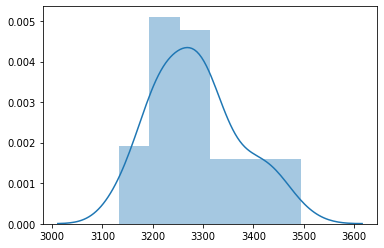

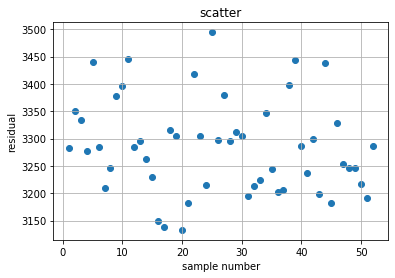

QQプロット


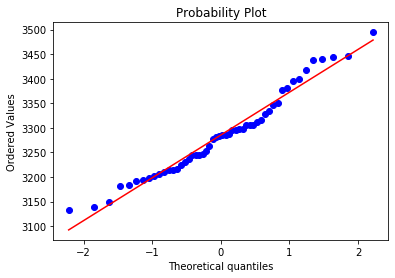

コルモゴロフスミルノフ検定:0.663624999591853
シャピロウィルク検定:0.15102702379226685


In [44]:
sum_list = []
for i in data:
    sum_list.append(np.sum(i))

print('[四方向,合計]')
print()
sns.distplot(sum_list)
plt.show()

x = np.arange(1, 53)
plt.scatter(x,sum_list)
plt.title("scatter")
plt.xlabel("sample number")
plt.ylabel("residual")
plt.grid(True)
plt.show()

print('QQプロット')
qq(sum_list)
a = kolmogorov_smirnov(sum_list)
b = shapiro_wilk(sum_list)
    
print(f'コルモゴロフスミルノフ検定:{a}')
print(f'シャピロウィルク検定:{b}')

[四方向,合計]



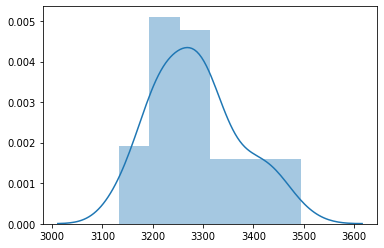

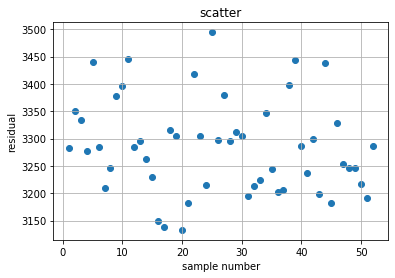

QQプロット


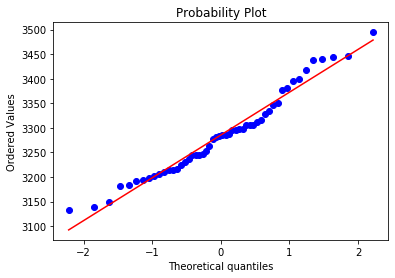

コルモゴロフスミルノフ検定:0.663624999591853
シャピロウィルク検定:0.15102702379226685


In [45]:
mean_list = []
for i in data:
    mean_list.append(np.sum(i))

print('[四方向,合計]')
print()
sns.distplot(mean_list)
plt.show()

x = np.arange(1, 53)
plt.scatter(x,mean_list)
plt.title("scatter")
plt.xlabel("sample number")
plt.ylabel("residual")
plt.grid(True)
plt.show()

print('QQプロット')
qq(mean_list)
a = kolmogorov_smirnov(mean_list)
b = shapiro_wilk(mean_list)
    
print(f'コルモゴロフスミルノフ検定:{a}')
print(f'シャピロウィルク検定:{b}')

## 検定結果
    残差データの合計値，平均値は正規性を持っている

- 四方向の残差合計値，残差平均値

  - コルモゴロフスミルノフ検定:棄却されない
  - シャピロウィルク検定:棄却される


- 八方向の残差合計値，残差平均値

  - コルモゴロフスミルノフ検定:棄却されない
  - シャピロウィルク検定:棄却されない
  